In [22]:
# !pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)
import torch.nn as nn

1.5.1+cu101


### 1. Data Generation  (Preparation)

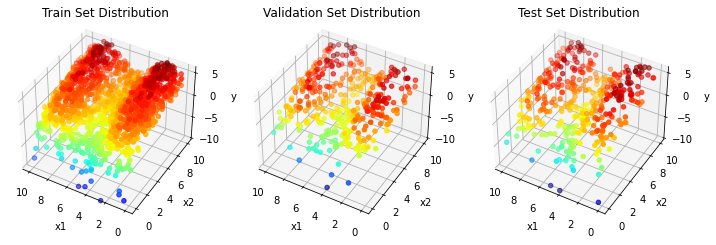

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# ====== Generating Dataset ====== #
num_data = 2400
x1 = np.random.rand(num_data) * 10
x2 = np.random.rand(num_data) * 10
e = np.random.normal(0, 0.5, num_data)
X = np.array([x1, x2]).T
y = 2*np.sin(x1) + np.log(0.5*x2**2) + e
# ====== Split Dataset into Train, Validation, Test ======#
train_X, train_y = X[:1600, :], y[:1600]
val_X, val_y = X[1600:2000, :], y[1600:2000]
test_X, test_y = X[2000:, :], y[2000:]

# ====== Visualize Each Dataset ====== #
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter(train_X[:, 0], train_X[:, 1], train_y, c=train_y, cmap='jet')

ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')
ax1.set_title('Train Set Distribution')
ax1.set_zlim(-10, 6)
ax1.view_init(40, -60)
ax1.invert_xaxis()

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(val_X[:, 0], val_X[:, 1], val_y, c=val_y, cmap='jet')

ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('y')
ax2.set_title('Validation Set Distribution')
ax2.set_zlim(-10, 6)
ax2.view_init(40, -60)
ax2.invert_xaxis()

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')

ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_zlabel('y')
ax3.set_title('Test Set Distribution')
ax3.set_zlim(-10, 6)
ax3.view_init(40, -60)
ax3.invert_xaxis()

plt.show()

### 2. Hypothesis Define (Model Define)  

Linear Regression 시에 활용하는 H(x) = Wx + b를 파이토치로 구현할 때는 단순하게 `nn.Linear` 모듈을 하나 만들어주면 됩니다. 이 때`in_features`는 x의 차원이고, `out_features`는 y의 차원입니다.  


**Linear Model**   
$$H = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 1}, b \in \mathcal{R}^{1}, H \in \mathcal{R}^{N \times 1})$$


**MLP Model**
$$Let \ relu(X) = \ max(X, 0)$$  

$$h = \ relu(X W_1 + b_1) \ \  ( W_1 \in \mathcal{R}^{2 \times 200}, b_1 \in \mathcal{R}^{200}, h \in \mathcal{R}^{N \times 200})$$  

$$H = \ h W_2 + b_2  \ \  ( W_2 \in \mathcal{R}^{200 \times 1}, b_2 \in \mathcal{R}^{1}, H \in \mathcal{R}^{N  \times 1})$$

## LinearModel Class

In [3]:
class LinearModel(nn.Module):
    # 초기화 및 입력값을 어떤 것 받을 것인지 지정할 때 문법
    # 형식은 항상 동일함
    def __init__(self):
        super(LinearModel, self).__init__()
        # hidden layer 없을 때
        self.linear = nn.Linear(in_feature=2, out_feature=1, bias=True)
        
    # 실질적으로 구현    
    def forward(self, x):
        return self.linear(x) 

## MLPModel Class

In [23]:
class MLPModel(nn.Module):
    # 클래스 선언할 때의 문법
    def __init__(self, in_dim, out_dim, hid_dim):
        super(MLPModel, self).__init__()
        # hidden layer이 있으니 in_dim에서 hid_dim으로 한번 보내고 다시hid_dim에서 out_dim으로 보냄
        self.linear1 = nn.Linear(in_dim, hid_dim)
        self.linear2 = nn.Linear(hid_dim, out_dim)
        # Activation function
        self.act = nn.ReLU()
        
    # x를 input으로 받았을 때 구현
    def forward(self, x):
        # x를 linear1 거쳐간 것으로 최신화
        x = self.linear1(x)
        # 최신화된 x에 activation function에 적용.
        x = self.act(x)
        # activation function 적용된 x에 linear2 거침
        x = self.linear2(x)
        # x 리턴
        return x
    
# in_dim = 2, hid_dim = 200, out_dim = 1인 MLPModel 객체 m 생성
m = MLPModel(2,1,200)

## MY_MLPModel with nn.ModuleList

In [29]:
class My_MLPModel(nn.Module):
    def __init__(self, hidden_nodes):
        super().__init__()
        nodes = (784,) + hidden_nodes + (10,)
        depth = len(nodes)
        linears = [nn.Linear(nodes[i], nodes[i+1]) for i in range(depth-1)]
        self.linears = nn.ModuleList(linears)
        self.relu = nn.ReLU()
        self.depth = depth
        
    def forward(self, x):
        for linear in self.linears:
            x = linear(x)
            x = self.relu(x)
        return x

In [4]:
reg_loss = nn.MSELoss()

# uncomment for testing Loss Function
# input이 뭐고 어떻게 넣어줘야할 지 모르겠을때는 테스트를 해보자.
# torch에서 넣어줄때는 torch.tensor로 변환하여 넣어주자
"""
test_pred_y = torch.Tensor([0,0,0,0])
test_true_y = torch.Tensor([0,1,0,1])

print(reg_loss(test_pred_y, test_true_y))
print(reg_loss(test_true_y, test_true_y))
"""

'\ntest_pred_y = torch.Tensor([0,0,0,0])\ntest_true_y = torch.Tensor([0,1,0,1])\n\nprint(reg_loss(test_pred_y, test_true_y))\nprint(reg_loss(test_true_y, test_true_y))\n'











  0%|          | 0/4000 [00:00<?, ?it/s]

801 parameters


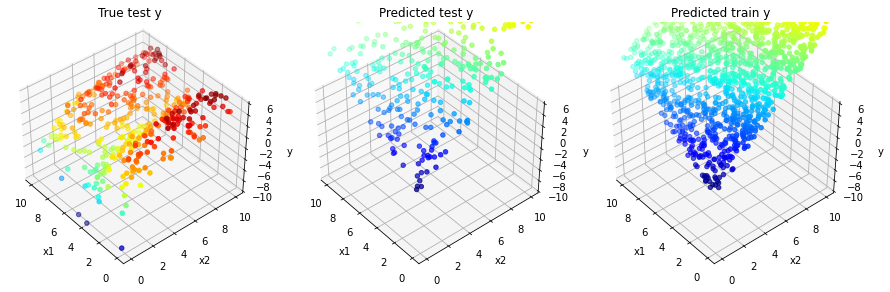











  0%|          | 1/4000 [00:00<29:31,  2.26it/s]









  1%|          | 37/4000 [00:00<20:32,  3.22it/s]

0 tensor(176.6929, grad_fn=<MseLossBackward>)












  3%|▎         | 112/4000 [00:00<14:07,  4.59it/s]









  5%|▍         | 194/4000 [00:00<09:42,  6.54it/s]

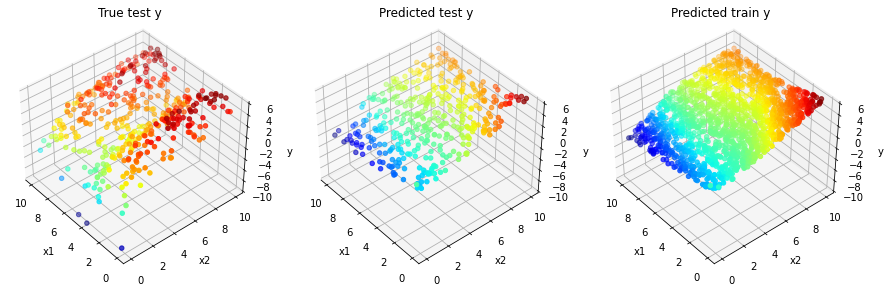











  6%|▌         | 240/4000 [00:01<06:57,  9.01it/s]









  8%|▊         | 317/4000 [00:01<04:47, 12.81it/s]

200 tensor(2.5962, grad_fn=<MseLossBackward>)












  9%|▉         | 378/4000 [00:01<03:19, 18.13it/s]

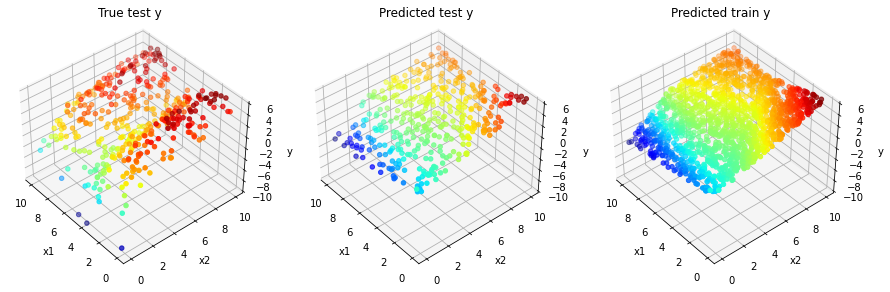











 11%|█         | 428/4000 [00:02<02:28, 23.98it/s]









 13%|█▎        | 503/4000 [00:02<01:43, 33.78it/s]

400 tensor(2.4050, grad_fn=<MseLossBackward>)












 14%|█▍        | 557/4000 [00:02<01:13, 46.99it/s]

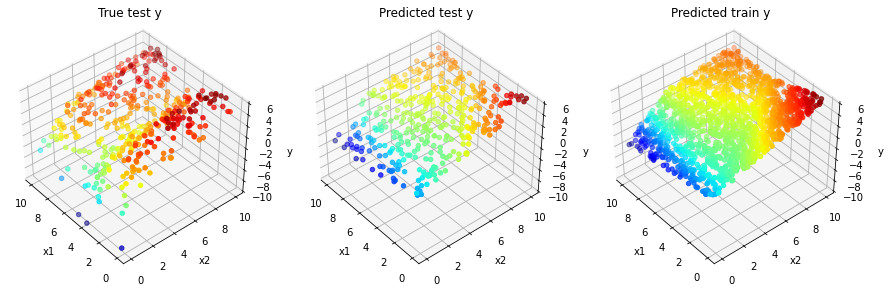











 15%|█▌        | 608/4000 [00:02<01:00, 55.85it/s]









 17%|█▋        | 675/4000 [00:02<00:43, 77.01it/s]

600 tensor(2.2680, grad_fn=<MseLossBackward>)












 18%|█▊        | 722/4000 [00:03<00:32, 99.84it/s]









 19%|█▉        | 777/4000 [00:03<00:24, 132.25it/s]

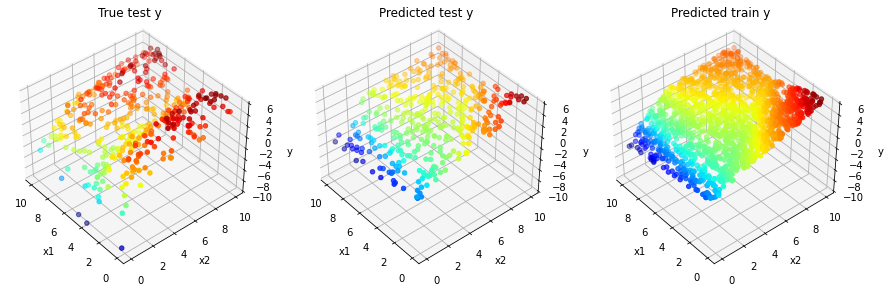











 21%|██        | 823/4000 [00:03<00:28, 110.71it/s]









 22%|██▏       | 893/4000 [00:03<00:21, 147.57it/s]

800 tensor(2.1241, grad_fn=<MseLossBackward>)












 24%|██▎       | 945/4000 [00:03<00:16, 187.34it/s]

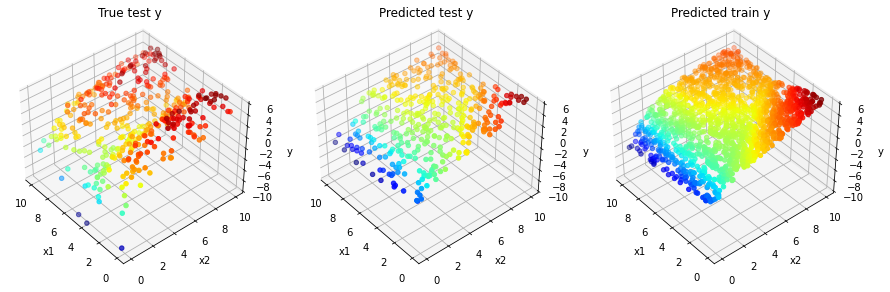











 25%|██▌       | 1001/4000 [00:04<00:19, 152.97it/s]









 26%|██▌       | 1044/4000 [00:04<00:15, 189.47it/s]

1000 tensor(1.9815, grad_fn=<MseLossBackward>)












 27%|██▋       | 1090/4000 [00:04<00:12, 227.60it/s]









 29%|██▊       | 1141/4000 [00:04<00:10, 272.78it/s]

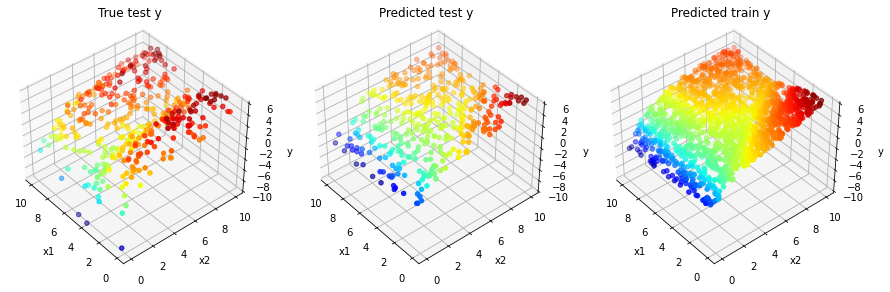











 30%|███       | 1201/4000 [00:05<00:14, 189.96it/s]









 31%|███▏      | 1250/4000 [00:05<00:11, 232.50it/s]

1200 tensor(1.8718, grad_fn=<MseLossBackward>)












 33%|███▎      | 1305/4000 [00:05<00:09, 277.09it/s]









 34%|███▍      | 1365/4000 [00:05<00:07, 330.06it/s]

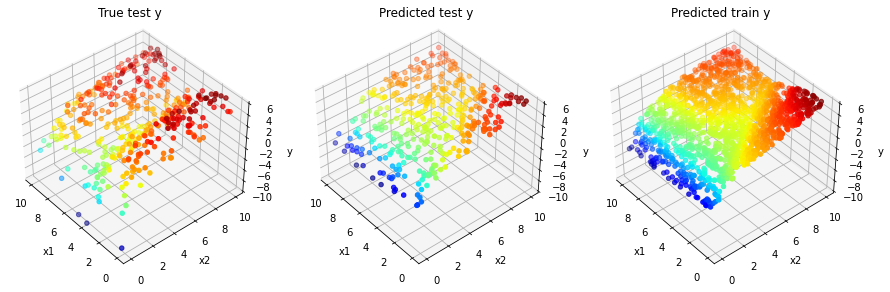











 35%|███▌      | 1412/4000 [00:06<00:15, 168.90it/s]









 37%|███▋      | 1478/4000 [00:06<00:11, 217.34it/s]

1400 tensor(1.7720, grad_fn=<MseLossBackward>)












 38%|███▊      | 1537/4000 [00:06<00:09, 268.02it/s]

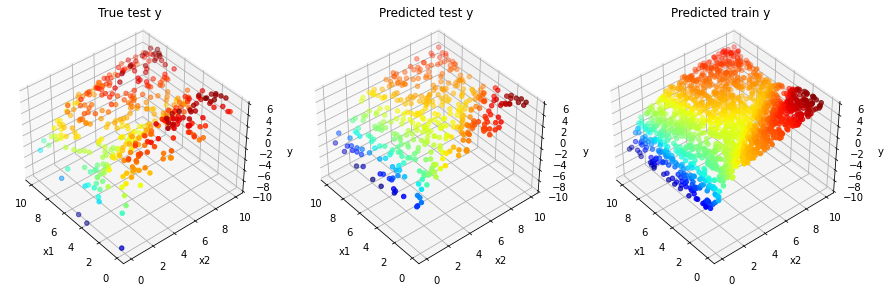











 40%|████      | 1601/4000 [00:06<00:12, 198.03it/s]









 41%|████      | 1649/4000 [00:07<00:09, 240.20it/s]

1600 tensor(1.6772, grad_fn=<MseLossBackward>)












 42%|████▏     | 1695/4000 [00:07<00:08, 277.95it/s]









 43%|████▎     | 1737/4000 [00:07<00:07, 291.94it/s]









 45%|████▍     | 1782/4000 [00:07<00:06, 326.13it/s]

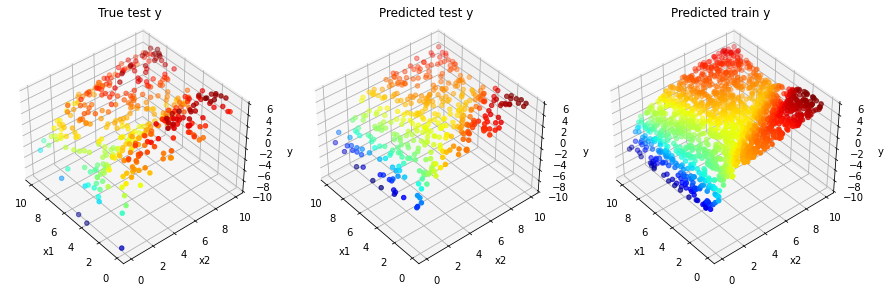











 46%|████▌     | 1823/4000 [00:07<00:13, 157.04it/s]

1800 tensor(1.5870, grad_fn=<MseLossBackward>)












 47%|████▋     | 1888/4000 [00:08<00:10, 203.00it/s]









 49%|████▊     | 1941/4000 [00:08<00:08, 248.79it/s]

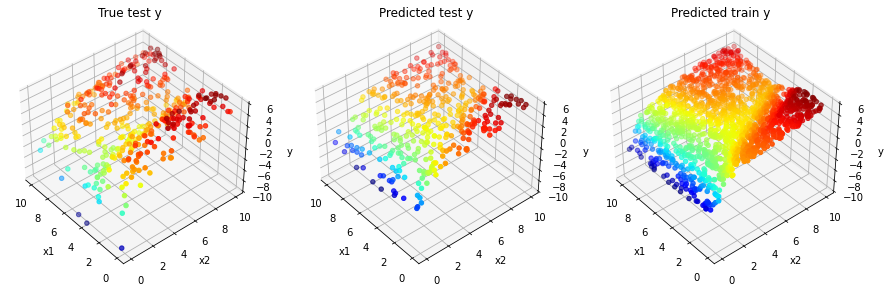











 50%|█████     | 2001/4000 [00:08<00:10, 182.68it/s]









 51%|█████     | 2038/4000 [00:08<00:09, 214.15it/s]

2000 tensor(1.5111, grad_fn=<MseLossBackward>)












 52%|█████▏    | 2084/4000 [00:08<00:07, 253.72it/s]









 53%|█████▎    | 2129/4000 [00:08<00:06, 291.79it/s]









 55%|█████▍    | 2193/4000 [00:09<00:05, 348.39it/s]

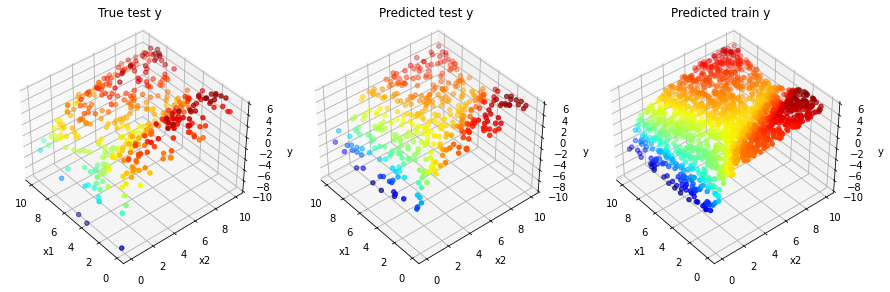











 56%|█████▌    | 2241/4000 [00:09<00:09, 181.39it/s]

2200 tensor(1.4437, grad_fn=<MseLossBackward>)












 58%|█████▊    | 2313/4000 [00:09<00:07, 233.72it/s]









 59%|█████▉    | 2369/4000 [00:09<00:05, 283.04it/s]

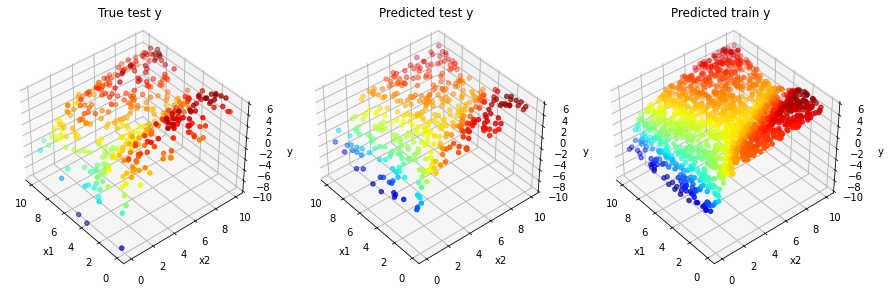











 60%|██████    | 2419/4000 [00:10<00:09, 164.40it/s]









 62%|██████▏   | 2489/4000 [00:10<00:07, 213.00it/s]

2400 tensor(1.3890, grad_fn=<MseLossBackward>)












 64%|██████▎   | 2547/4000 [00:10<00:05, 262.67it/s]

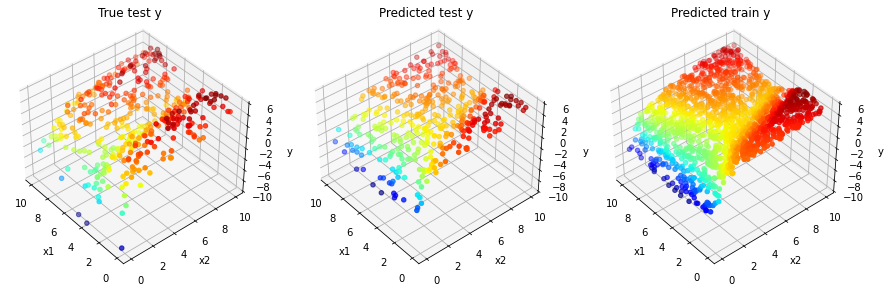











 65%|██████▌   | 2601/4000 [00:11<00:07, 183.62it/s]









 66%|██████▌   | 2640/4000 [00:11<00:06, 217.62it/s]

2600 tensor(1.3482, grad_fn=<MseLossBackward>)












 68%|██████▊   | 2703/4000 [00:11<00:04, 270.73it/s]









 69%|██████▉   | 2764/4000 [00:11<00:03, 324.34it/s]

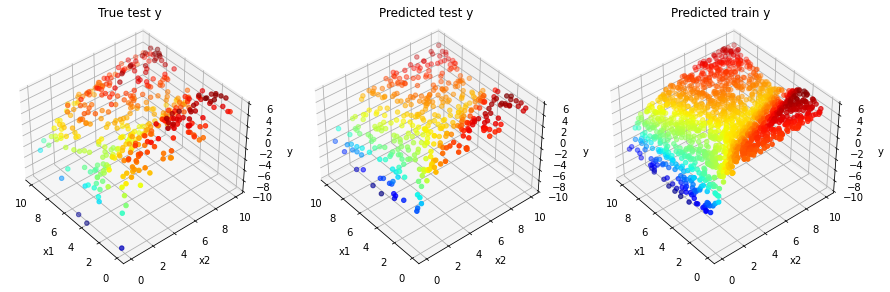











 70%|███████   | 2814/4000 [00:11<00:06, 180.52it/s]









 72%|███████▏  | 2876/4000 [00:12<00:04, 229.23it/s]

2800 tensor(1.3166, grad_fn=<MseLossBackward>)












 73%|███████▎  | 2921/4000 [00:12<00:04, 253.25it/s]









 74%|███████▍  | 2973/4000 [00:12<00:03, 298.34it/s]

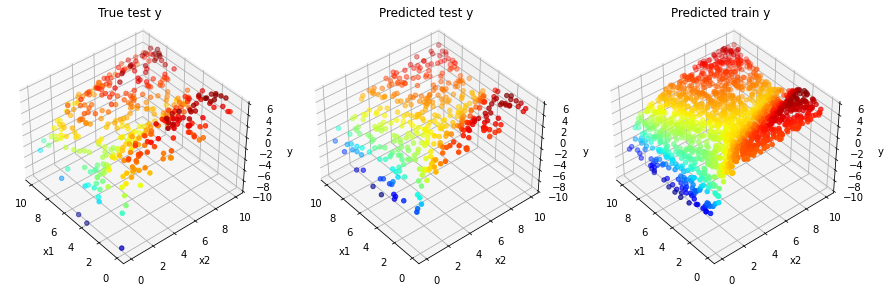











 75%|███████▌  | 3018/4000 [00:12<00:05, 168.51it/s]









 77%|███████▋  | 3087/4000 [00:12<00:04, 217.86it/s]

3000 tensor(1.2864, grad_fn=<MseLossBackward>)












 78%|███████▊  | 3133/4000 [00:13<00:03, 255.87it/s]

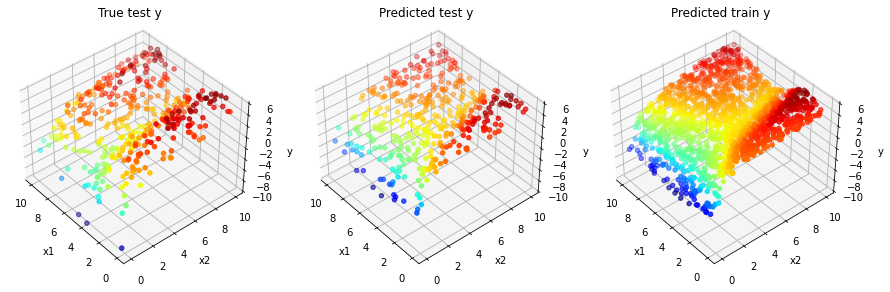











 80%|████████  | 3201/4000 [00:13<00:04, 196.39it/s]









 81%|████████▏ | 3255/4000 [00:13<00:03, 242.43it/s]

3200 tensor(1.2578, grad_fn=<MseLossBackward>)












 83%|████████▎ | 3312/4000 [00:13<00:02, 292.88it/s]









 85%|████████▍ | 3390/4000 [00:13<00:01, 359.93it/s]

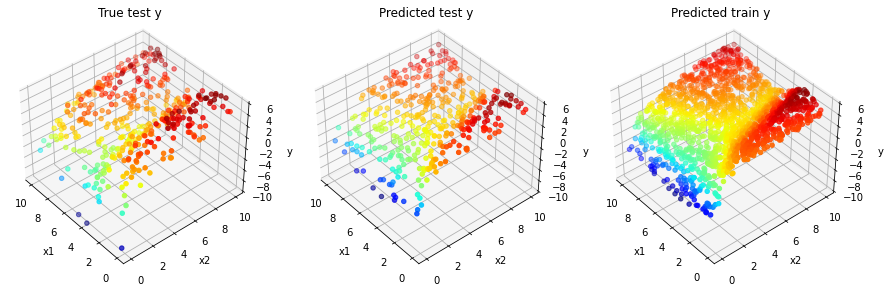











 86%|████████▌ | 3445/4000 [00:14<00:02, 192.08it/s]

3400 tensor(1.2329, grad_fn=<MseLossBackward>)












 87%|████████▋ | 3489/4000 [00:14<00:02, 230.17it/s]









 88%|████████▊ | 3535/4000 [00:14<00:01, 270.35it/s]

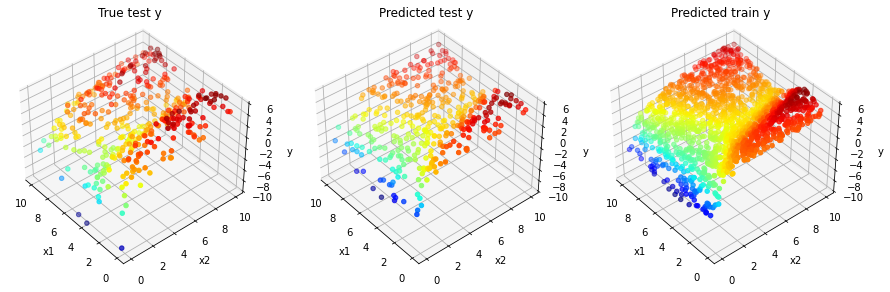











 90%|█████████ | 3601/4000 [00:15<00:02, 187.78it/s]









 91%|█████████▏| 3655/4000 [00:15<00:01, 233.26it/s]

3600 tensor(1.2110, grad_fn=<MseLossBackward>)












 93%|█████████▎| 3725/4000 [00:15<00:00, 288.21it/s]









 95%|█████████▍| 3793/4000 [00:15<00:00, 348.28it/s]

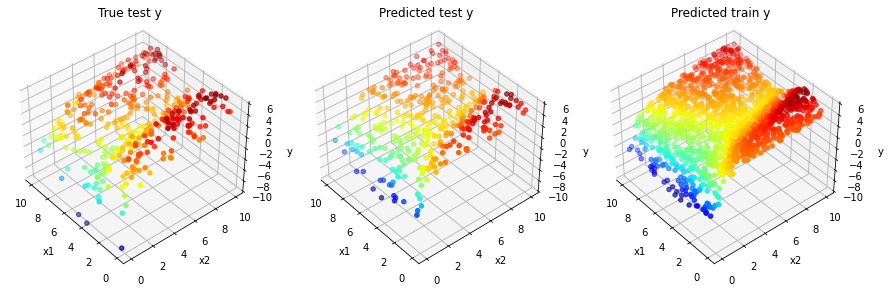











 96%|█████████▌| 3847/4000 [00:16<00:00, 199.77it/s]









 98%|█████████▊| 3918/4000 [00:16<00:00, 254.38it/s]

3800 tensor(1.1915, grad_fn=<MseLossBackward>)












100%|██████████| 4000/4000 [00:16<00:00, 244.26it/s]


In [34]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm


# ====== Construct Model ====== #
model = MLPModel(2, 1, 200) # Model을 생성해줍니다.
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.

# ===== Construct Optimizer ====== #
lr = 0.005 # Learning Rate를 하나 정해줍니다. (원할한 학습을 위해 손을 많이 탑니다)
optimizer = optim.SGD(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.

# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트를 만들어줍시다.
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_mae = []
list_mae_epoch = []


epoch = 4000 # 학습 횟수(epoch)을 지정해줍시다.
for i in tqdm(range(epoch)):
    
    # ====== Train ====== #
    model.train() # model을 train 모드로 세팅합니다. 반대로 향후 모델을 평가할 때는 eval() 모드로 변경할 겁니다 (나중 실습에서 쓸 겁니다)
    optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화해줍니다.
    
    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y)
    pred_y = model(input_x)
    #print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원을 체크해봅니다.
    
    loss = reg_loss(pred_y.squeeze(), true_y) # squeeze를 이용하여 불필요한 ,1 삭제
    loss.backward() # backward()를 통해서 그라디언트를 구해줍니다.
    optimizer.step() # step()을 통해서 그라디언틀르 바탕으로 파라미터를 업데이트 해줍니다. 
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy())
    
    
    # ====== Validation ====== #
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y)
    pred_y = model(input_x)   
    loss = reg_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
    

    # ====== Evaluation ======= #
    if i % 200 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
        
        # ====== Calculate MAE ====== #
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().numpy() 
        mae = mean_absolute_error(true_y, pred_y) # sklearn 쪽 함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것에 주의합시다
        list_mae.append(mae)
        list_mae_epoch.append(i)
        
        fig = plt.figure(figsize=(15,5))
        
        # ====== True Y Scattering ====== #
        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
        ax1.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')
        
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_zlabel('y')
        ax1.set_zlim(-10, 6)
        ax1.view_init(40, -40)
        ax1.set_title('True test y')
        ax1.invert_xaxis()

        # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2, projection='3d')
        ax2.scatter(test_X[:, 0], test_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_zlabel('y')
        ax2.set_zlim(-10, 6)
        ax2.view_init(40, -40)
        ax2.set_title('Predicted test y')
        ax2.invert_xaxis()

        # ====== Just for Visualizaing with High Resolution ====== #
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3, projection='3d')
        ax3.scatter(train_X[:, 0], train_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_zlabel('y')
        ax3.set_zlim(-10, 6)
        ax3.view_init(40, -40)
        ax3.set_title('Predicted train y')
        ax3.invert_xaxis()
        
        plt.show()
        print(i, loss)

# Test

In [31]:
import torch.optim as optim
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

# ====== Construct Model ====== #
model = MY_MLPModel(10) # Model을 생성해줍니다.
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.

# ===== Construct Optimizer ====== #
lr = 0.005 # Learning Rate를 하나 정해줍니다. (원할한 학습을 위해 손을 많이 탑니다)
optimizer = optim.SGD(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.

# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트를 만들어줍시다.
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_mae = []
list_mae_epoch = []


epoch = 4000 # 학습 횟수(epoch)을 지정해줍시다.
for i in tqdm(range(epoch)):
    
    # ====== Train ====== #
    model.train() # model을 train 모드로 세팅합니다. 반대로 향후 모델을 평가할 때는 eval() 모드로 변경할 겁니다 (나중 실습에서 쓸 겁니다)
    optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화해줍니다.
    
    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y)
    pred_y = model(input_x)
    #print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원을 체크해봅니다.
    
    loss = reg_loss(pred_y.squeeze(), true_y) # squeeze를 이용하여 불필요한 ,1 삭제
    loss.backward() # backward()를 통해서 그라디언트를 구해줍니다.
    optimizer.step() # step()을 통해서 그라디언틀르 바탕으로 파라미터를 업데이트 해줍니다. 
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy())
    
    
    # ====== Validation ====== #
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y)
    pred_y = model(input_x)   
    loss = reg_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
    

    # ====== Evaluation ======= #
    if i % 200 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
        
        # ====== Calculate MAE ====== #
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().numpy() 
        mae = mean_absolute_error(true_y, pred_y) # sklearn 쪽 함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것에 주의합시다
        list_mae.append(mae)
        list_mae_epoch.append(i)
        
        fig = plt.figure(figsize=(15,5))
        
        # ====== True Y Scattering ====== #
        ax1 = fig.add_subplot(1, 3, 1, projection='3d')
        ax1.scatter(test_X[:, 0], test_X[:, 1], test_y, c=test_y, cmap='jet')
        
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_zlabel('y')
        ax1.set_zlim(-10, 6)
        ax1.view_init(40, -40)
        ax1.set_title('True test y')
        ax1.invert_xaxis()

        # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2, projection='3d')
        ax2.scatter(test_X[:, 0], test_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_zlabel('y')
        ax2.set_zlim(-10, 6)
        ax2.view_init(40, -40)
        ax2.set_title('Predicted test y')
        ax2.invert_xaxis()

        # ====== Just for Visualizaing with High Resolution ====== #
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3, projection='3d')
        ax3.scatter(train_X[:, 0], train_X[:, 1], pred_y, c=pred_y[:,0], cmap='jet')

        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_zlabel('y')
        ax3.set_zlim(-10, 6)
        ax3.view_init(40, -40)
        ax3.set_title('Predicted train y')
        ax3.invert_xaxis()
        
        plt.show()
        print(i, loss)

ModuleNotFoundError: No module named 'MY_MLPModel'

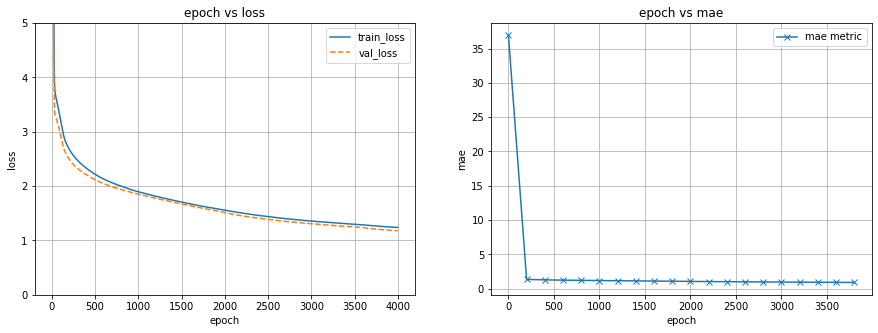

In [9]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 5)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_mae_epoch, list_mae, marker='x', label='mae metric')

ax2.set_xlabel('epoch')
ax2.set_ylabel('mae')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs mae')


plt.show()

# Assignment1. MNIST Digit Recogntion

### 1. Data Preparation

In [16]:
!pwd

/home/euiseokjeong/Desktop/WIL-What-I-learned-


In [21]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn

batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

Using downloaded and verified file: ./data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [33]:
from notebook.auth import passwd
passwd()

Enter password: ········
Verify password: ········


'sha1:3b8504e82a94:03de848c06399ec78f23c709170a03f3e1f08351'